In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas.util.testing as tm

C:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [2]:
# Reading in the cleaned data set from the previous phase
df_ecom2 = pd.read_csv('df_ecom2.csv')
df_ecom2 = df_ecom2.iloc[:,1:21]
df_ecom2.head()

,CustomerID,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus,Complain
0,50001.0,4.0,6.0,3.0,3.0,2.0,9.0,11.0,1.0,1.0,5.0,159.93,Yes,Mobile Phone,Tier-3,Debit Card,Female,Laptop & Accessory,Single,Yes
1,50002.0,9.0,8.0,3.0,4.0,3.0,7.0,15.0,0.0,1.0,0.0,120.90,Yes,Mobile Phone,Tier-1,UPI,Male,Mobile,Single,Yes
2,50003.0,9.0,30.0,2.0,4.0,3.0,6.0,14.0,0.0,1.0,3.0,120.28,Yes,Mobile Phone,Tier-1,Debit Card,Male,Mobile,Single,Yes
3,50004.0,0.0,15.0,2.0,4.0,5.0,8.0,23.0,0.0,1.0,3.0,134.07,Yes,Mobile Phone,Tier-3,Debit Card,Male,Laptop & Accessory,Single,No
4,50005.0,0.0,12.0,3.0,3.0,5.0,3.0,11.0,1.0,1.0,3.0,129.60,Yes,Mobile Phone,Tier-1,CC,Male,Mobile,Single,No


In [3]:
# Removing the Customer ID variable as it is not relevant for modelling
df_ecom2.drop('CustomerID',axis=1,inplace=True)

In [4]:
# Imbalance in the target variable
df_ecom2['Churn'].value_counts()/len(df_ecom2)

No     0.831616
Yes    0.168384
Name: Churn, dtype: float64

We can see from the above there is a good amount of class imbalance in the data w.r.t the target variable i.e. churn. To take care of this imbalance we will have to apply SMOTE. Before applying SMOTE we will split the data into training and testing sets to avoid introducing bias in the test data set.

In [5]:
# Splitting into the train test samples
X = df_ecom2.loc[:,df_ecom2.columns != 'Churn']
Y = df_ecom2.loc[:,df_ecom2.columns == 'Churn']
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [6]:
# Converting the above datasets into a sparse matrix
X_train_s = pd.get_dummies(X_train,drop_first=True)
X_test_s = pd.get_dummies(X_test)
X_test_s = X_test_s[X_train_s.columns]
Y_train_s = pd.get_dummies(Y_train,drop_first=True)
Y_test_s = pd.get_dummies(Y_test)[Y_train_s.columns]

In [7]:
# SMOTE
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=1234)
os_data_X,os_data_Y = os.fit_sample(X_train_s,Y_train_s)
os_data_X = pd.DataFrame(os_data_X,columns = X_train_s.columns)
os_data_Y = pd.DataFrame(os_data_Y,columns = Y_train_s.columns)

In [8]:
os_data_Y['Churn_Yes'].sum()/len(os_data_Y)

0.5

We can see from above that the proportion of the minority class i.e. *Churn_yes* has been increased from approximately 17% to 50%.

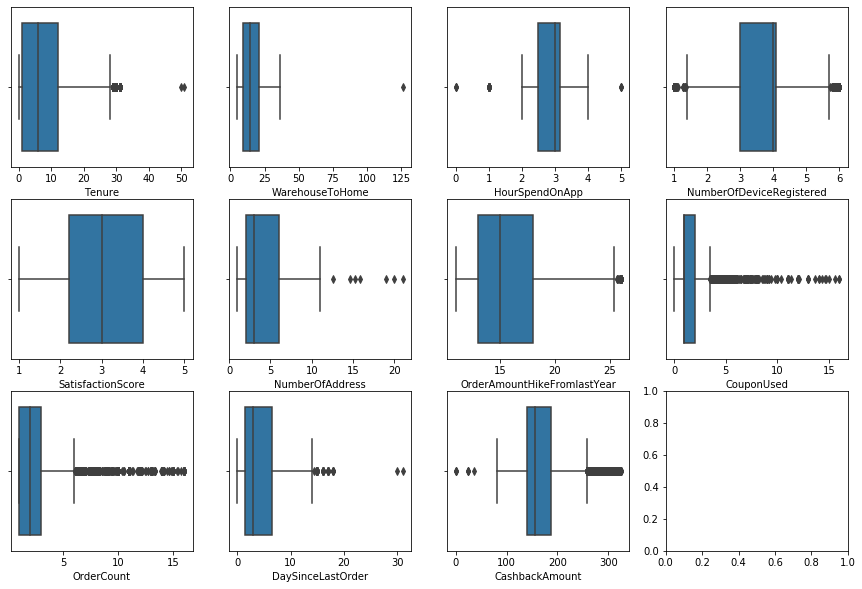

In [9]:
# Checking for outliers
num = list(os_data_X.dtypes[os_data_X.dtypes == 'float64'].index)
fig,axes = plt.subplots(3,4,figsize=(15,10))
for i,j in zip(num,axes.flatten()):
    sns.boxplot(x = i,data = os_data_X,ax = j)

We can see from above that a lot of outliers have come up in the numeric variables, this has happened because of the oversampling exercise that we have done. These outliers will have to be treated.

In [10]:
# Treating the outliers using winsorization
def remove_outlier(col):
    sorted(col) # Sorting the column
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range
for i in num:
    ll,ul = remove_outlier(os_data_X[i])
    os_data_X[i] = np.where(os_data_X[i]>ul,os_data_X[i].quantile(0.95),os_data_X[i])
    os_data_X[i] = np.where(os_data_X[i]<ll,os_data_X[i].quantile(0.05),os_data_X[i]) 

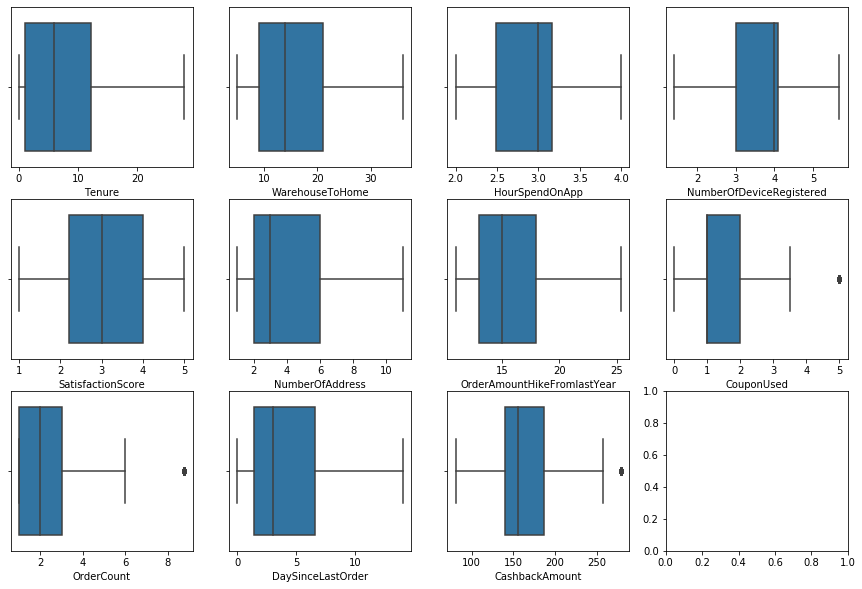

In [11]:
num = list(os_data_X.dtypes[os_data_X.dtypes == 'float64'].index)
fig,axes = plt.subplots(3,4,figsize=(15,10))
for i,j in zip(num,axes.flatten()):
    sns.boxplot(x = i,data = os_data_X,ax = j)

In [12]:
# Building the first baseline model
import statsmodels.api as sm
logit_mod = sm.Logit(os_data_Y,os_data_X)
result = logit_mod.fit()
coef_summary = pd.DataFrame(result.params,columns=['Coef'])
coef_summary['Pvalue'] = result.pvalues
coef_summary

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


,Coef,Pvalue
Tenure,-0.175776,5.353884e-148
WarehouseToHome,0.042088,8.308725e-19
HourSpendOnApp,0.081741,1.983851e-01
NumberOfDeviceRegistered,0.590925,1.830086e-34
SatisfactionScore,0.336878,5.661767e-32
NumberOfAddress,0.245279,5.851904e-50
OrderAmountHikeFromlastYear,0.005564,5.902669e-01
CouponUsed,0.101954,7.631436e-03
OrderCount,0.114643,8.622147e-07
DaySinceLastOrder,-0.143613,1.465132e-21


In [13]:
# Identifying the non significant variables
coef_summary[coef_summary['Pvalue']>0.05]

,Coef,Pvalue
HourSpendOnApp,0.081741,0.198385
OrderAmountHikeFromlastYear,0.005564,0.590267
CityTier_Tier-2,0.408426,0.054486
Gender_Male,0.065213,0.386052
PreferedOrderCat_Grocery,-0.023006,0.931884


In [14]:
coef_summary[coef_summary['Pvalue']<0.05].index

Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile Phone', 'CityTier_Tier-3',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Others', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Complain_Yes'],
      dtype='object')

In [15]:
# Fully significant model for interpretation
os_data_X = os_data_X[['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile Phone', 'CityTier_Tier-3',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Others', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Complain_Yes']]
X_test_s = X_test_s[['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile Phone', 'CityTier_Tier-3',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Others', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Complain_Yes']]
import statsmodels as sm
logit_mod = sm.api.Logit(os_data_Y,os_data_X)
result = logit_mod.fit()
coef_summary = pd.DataFrame(result.params,columns=['Coef'])
coef_summary['Pvalue'] = result.pvalues
coef_summary

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


,Coef,Pvalue
Tenure,-0.176391,2.958180e-153
WarehouseToHome,0.042453,9.145555e-20
NumberOfDeviceRegistered,0.617381,7.187667e-42
SatisfactionScore,0.337325,1.042669e-32
NumberOfAddress,0.248325,1.855904e-52
OrderCount,0.151730,7.208745e-17
DaySinceLastOrder,-0.138856,9.281133e-21
CashbackAmount,-0.010851,6.394288e-18
PreferredLoginDevice_Mobile Phone,-0.842773,4.702169e-28
CityTier_Tier-3,0.557423,5.645748e-08


In [16]:
# Interpreting the Coefficients
coef_summary['Odds'] = np.exp(coef_summary['Coef'])
coef_summary['Prob'] = (coef_summary['Odds'])/(coef_summary['Odds']+1)
coef_summary

,Coef,Pvalue,Odds,Prob
Tenure,-0.176391,2.958180e-153,0.838290,0.456016
WarehouseToHome,0.042453,9.145555e-20,1.043367,0.510612
NumberOfDeviceRegistered,0.617381,7.187667e-42,1.854066,0.649623
SatisfactionScore,0.337325,1.042669e-32,1.401194,0.583540
NumberOfAddress,0.248325,1.855904e-52,1.281876,0.561764
OrderCount,0.151730,7.208745e-17,1.163846,0.537860
DaySinceLastOrder,-0.138856,9.281133e-21,0.870353,0.465342
CashbackAmount,-0.010851,6.394288e-18,0.989208,0.497287
PreferredLoginDevice_Mobile Phone,-0.842773,4.702169e-28,0.430515,0.300951
CityTier_Tier-3,0.557423,5.645748e-08,1.746167,0.635856


We can interpret the above model using the probability coefficients for example if a customer is in a tier-3 city the probability for churning increases by 63%, also for every unit increase in the cashback amount the probability reduces by 49.7% etc.

In [17]:
# Looking at the baseline accuracy scores 
from sklearn.metrics import confusion_matrix
con_mat_train = confusion_matrix(os_data_Y,round(result.predict(os_data_X),0))
print('Training Accuracy of Logistic Model: {:.3f}'.format((con_mat_train[0,0]+con_mat_train[1,1])/con_mat_train.sum()))
con_mat_test = confusion_matrix(Y_test_s,round(result.predict(X_test_s),0))
print('Test Accuracy of Logistic Model: {:.3f}'.format((con_mat_test[0,0]+con_mat_test[1,1])/con_mat_test.sum()))

Training Accuracy of Logistic Model: 0.839
Test Accuracy of Logistic Model: 0.795


We can see from the above accuracy scores that despite using the SMOTE only on the training data set the accuracy levels are fairly good, there is not much evidence of overfitting. We now proceed to create more models which can be evaluated against each other. We have carries out a basic level of feature extraction by removing variables which were not significantly impacting the propensity of a customer to churn.

In [109]:
X_train = os_data_X
Y_train = os_data_Y
X_test = X_test_s
Y_test = Y_test_s

### LOGISTIC REGRESSION

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
logreg1 = LogisticRegression(penalty='none',solver='lbfgs',random_state=1234,max_iter=1500)
logreg1.fit(X_train,Y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
Y_ptr_lr1 = logreg1.predict(X_train)
Y_pprtr_lr1 = logreg1.predict_proba(X_train)[:,1]
Y_pte_lr1 = logreg1.predict(X_test)
Y_pprte_lr1 = logreg1.predict_proba(X_test)[:,1]

In [112]:
LG_train_model_score = logreg1.score(X_train, Y_train)
print(LG_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_lr1))

0.835720816824139
[[2698  583]
 [ 495 2786]]


In [113]:
confusion_matrix(Y_train, Y_ptr_lr1)

array([[2698,  583],
       [ 495, 2786]], dtype=int64)

In [114]:
logreg1.score(X_train, Y_train)

0.835720816824139

In [115]:
print(classification_report(Y_train, Y_ptr_lr1))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3281
           1       0.83      0.85      0.84      3281

    accuracy                           0.84      6562
   macro avg       0.84      0.84      0.84      6562
weighted avg       0.84      0.84      0.84      6562



In [116]:
LG_test_model_score = logreg1.score(X_test, Y_test)
print(LG_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_lr1))

0.7939609236234458
[[1118  283]
 [  65  223]]


In [117]:
confusion_matrix(Y_test, Y_pte_lr1)

array([[1118,  283],
       [  65,  223]], dtype=int64)

In [118]:
logreg1.score(X_test, Y_test)

0.7939609236234458

In [32]:
print(classification_report(Y_test, Y_pte_lr1))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1401
           1       0.44      0.77      0.56       288

    accuracy                           0.79      1689
   macro avg       0.69      0.79      0.71      1689
weighted avg       0.86      0.79      0.81      1689



AUC: 0.922


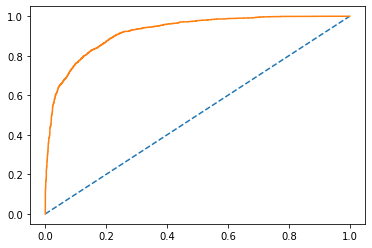

In [33]:
# predict probabilities
probs = logreg1.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
LG_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % LG_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.866


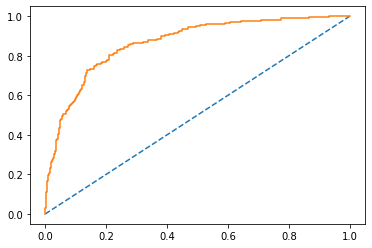

In [34]:
# predict probabilities
probs = logreg1.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
LG_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % LG_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### LDA

In [171]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

In [172]:
clfLDA = LinearDiscriminantAnalysis()
clfLDA.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [188]:
Y_ptr_ld=clfLDA.predict(X_train)
LDA_train_model_score = clfLDA.score(X_train, Y_train)
print(LDA_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_ld))

0.8367875647668394
[[2657  624]
 [ 447 2834]]


In [189]:
clfLDA.score(X_train, Y_train)

0.8367875647668394

In [190]:
confusion_matrix(Y_train, Y_ptr_ld)

array([[2657,  624],
       [ 447, 2834]], dtype=int64)

In [192]:
print(classification_report(Y_train, Y_ptr_ld))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      3281
           1       0.82      0.86      0.84      3281

    accuracy                           0.84      6562
   macro avg       0.84      0.84      0.84      6562
weighted avg       0.84      0.84      0.84      6562



In [193]:
Y_pte_ld=clfLDA.predict(X_test)
LDA_test_model_score = clfLDA.score(X_test, Y_test)
print(LDA_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_ld))

0.7809354647720544
[[1092  309]
 [  61  227]]


In [194]:
clfLDA.score(X_test, Y_test)

0.7809354647720544

In [195]:
confusion_matrix(Y_test, Y_pte_ld)

array([[1092,  309],
       [  61,  227]], dtype=int64)

In [196]:
print(classification_report(Y_test,Y_pte_ld))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1401
           1       0.42      0.79      0.55       288

    accuracy                           0.78      1689
   macro avg       0.69      0.78      0.70      1689
weighted avg       0.86      0.78      0.80      1689



AUC: 0.921


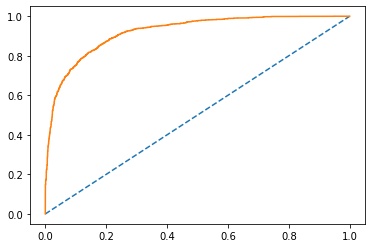

In [197]:
# predict probabilities
probs = clfLDA.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
LDA_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % LDA_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.858


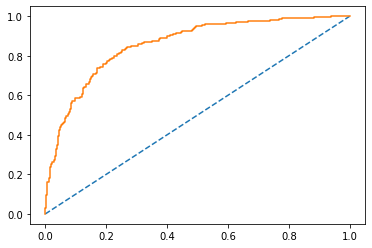

In [198]:
# predict probabilities
probs = clfLDA.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
LDA_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % LDA_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### KNN

In [199]:
from sklearn.neighbors import KNeighborsClassifier

clfKNN=KNeighborsClassifier()
clfKNN.fit(X_train,Y_train)


C:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [200]:
Y_ptr_knn=clfKNN.predict(X_train)
KNN_train_model_score = clfKNN.score(X_train, Y_train)
print(KNN_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_knn))

0.9245656811947577
[[2812  469]
 [  26 3255]]


In [201]:
clfKNN.score(X_train, Y_train)

0.9245656811947577

In [202]:
confusion_matrix(Y_train, Y_ptr_knn)

array([[2812,  469],
       [  26, 3255]], dtype=int64)

In [203]:
print(classification_report(Y_train, Y_ptr_knn))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3281
           1       0.87      0.99      0.93      3281

    accuracy                           0.92      6562
   macro avg       0.93      0.92      0.92      6562
weighted avg       0.93      0.92      0.92      6562



In [204]:
from sklearn.neighbors import KNeighborsClassifier
clfKNN=KNeighborsClassifier()
clfKNN.fit(X_train,Y_train)
Y_pte_knn=clfKNN.predict(X_test)
KNN_test_model_score = clfKNN.score(X_test, Y_test)
print(KNN_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_knn))

C:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.7933688573120189
[[1085  316]
 [  33  255]]


In [205]:
clfKNN.score(X_test, Y_test)

0.7933688573120189

In [206]:
confusion_matrix(Y_test, Y_pte_knn)

array([[1085,  316],
       [  33,  255]], dtype=int64)

In [207]:
print(classification_report(Y_test, Y_pte_knn))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1401
           1       0.45      0.89      0.59       288

    accuracy                           0.79      1689
   macro avg       0.71      0.83      0.73      1689
weighted avg       0.88      0.79      0.82      1689



AUC: 0.996


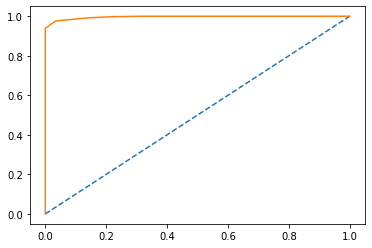

In [208]:
# predict probabilities
probs = clfKNN.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
KNN_train_auc= roc_auc_score(Y_train, probs)
print('AUC: %.3f' % KNN_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.908


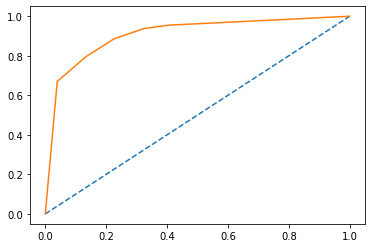

In [209]:
# predict probabilities
probs = clfKNN.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
KNN_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % KNN_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### NB

In [210]:
from sklearn.naive_bayes import GaussianNB
# Invoking the NB Gaussian function to create the model
# fitting the model in the training data set
modelNB = GaussianNB()
modelNB.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [212]:
Y_ptr_nb = modelNB.predict(X_train)
NB_train_model_score = modelNB.score(X_train, Y_train)
print(NB_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_nb))

0.758000609570253
[[2336  945]
 [ 643 2638]]


In [213]:
modelNB.score(X_train, Y_train)

0.758000609570253

In [214]:
confusion_matrix(Y_train, Y_ptr_nb)

array([[2336,  945],
       [ 643, 2638]], dtype=int64)

In [215]:
print(classification_report(Y_train, Y_ptr_nb))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75      3281
           1       0.74      0.80      0.77      3281

    accuracy                           0.76      6562
   macro avg       0.76      0.76      0.76      6562
weighted avg       0.76      0.76      0.76      6562



In [216]:
# Invoking the NB Gaussian function to create the model
# fitting the model in the training data set
modelNB = GaussianNB()
modelNB.fit(X_train, Y_train)
Y_pte_nb = modelNB.predict(X_test)
NB_test_model_score = modelNB.score(X_test, Y_test)
print(NB_test_model_score)
print(metrics.confusion_matrix(Y_test,Y_pte_nb))

0.6844286560094731
[[975 426]
 [107 181]]


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [217]:
modelNB.score(X_test, Y_test)

0.6844286560094731

In [218]:
confusion_matrix(Y_test, Y_pte_nb)

array([[975, 426],
       [107, 181]], dtype=int64)

In [219]:
print(classification_report(Y_test, Y_pte_nb))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1401
           1       0.30      0.63      0.40       288

    accuracy                           0.68      1689
   macro avg       0.60      0.66      0.59      1689
weighted avg       0.80      0.68      0.72      1689



AUC: 0.837


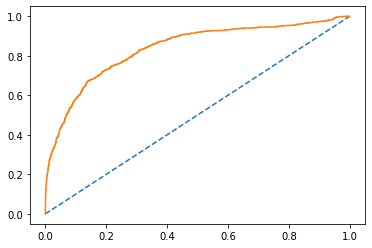

In [220]:
# predict probabilities
probs = modelNB.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
NB_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % NB_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.717


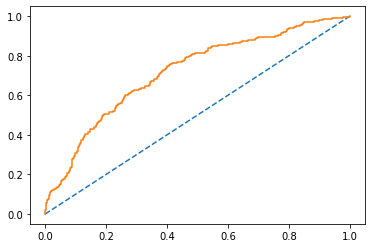

In [221]:
# predict probabilities
probs = modelNB.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
NB_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % NB_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### SVC

In [222]:
from sklearn import svm

clfSVM = svm.SVC(kernel='linear',probability=True)
clfSVM.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [223]:
Y_ptr_svc =clfSVM.predict(X_train)
SVM_train_model_score = clfSVM.score(X_train, Y_train)
print(SVM_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_svc))

0.8372447424565681
[[2687  594]
 [ 474 2807]]


In [224]:
clfSVM.score(X_train, Y_train)

0.8372447424565681

In [225]:
confusion_matrix(Y_train, Y_ptr_svc)

array([[2687,  594],
       [ 474, 2807]], dtype=int64)

In [226]:
Y_pte_svc=clfSVM.predict(X_test)
SVM_test_model_score = clfSVM.score(X_test, Y_test)
print(SVM_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_svc))

0.7939609236234458
[[1113  288]
 [  60  228]]


In [227]:
clfSVM.score(X_test, Y_test)

0.7939609236234458

In [228]:
confusion_matrix(Y_test, Y_pte_svc)

array([[1113,  288],
       [  60,  228]], dtype=int64)

In [229]:
print(classification_report(Y_train, Y_ptr_svc))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      3281
           1       0.83      0.86      0.84      3281

    accuracy                           0.84      6562
   macro avg       0.84      0.84      0.84      6562
weighted avg       0.84      0.84      0.84      6562



In [230]:
print(classification_report(Y_test, Y_pte_svc))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1401
           1       0.44      0.79      0.57       288

    accuracy                           0.79      1689
   macro avg       0.70      0.79      0.72      1689
weighted avg       0.86      0.79      0.81      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.921


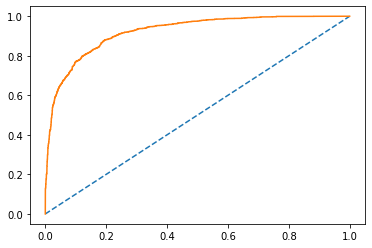

In [231]:
# predict probabilities
probs = clfSVM.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
SVM_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % SVM_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.868


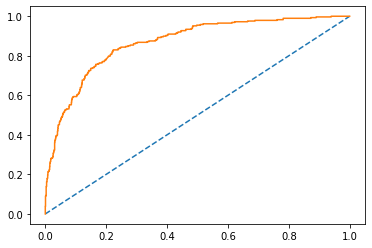

In [232]:
# predict probabilities
probs = clfSVM.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
SVM_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % SVM_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

## Decision Tree

In [233]:
from sklearn.tree import DecisionTreeClassifier
DT_model= DecisionTreeClassifier(criterion = 'gini',
                                splitter = 'best',
                                max_depth = None,
                                min_samples_split =100,
                                min_samples_leaf = 40,
                                max_leaf_nodes = None,
                                min_impurity_decrease = 0.000)
DT_model.fit(X_train,Y_train.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [234]:
Y_ptr_dt = DT_model.predict(X_train)
model_score = DT_model.score(X_train, Y_train)
print(model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_dt))

0.8594940566900335
[[2808  473]
 [ 449 2832]]


In [235]:
 DT_model.score(X_train, Y_train)

0.8594940566900335

In [236]:
confusion_matrix(Y_train, Y_ptr_dt)

array([[2808,  473],
       [ 449, 2832]], dtype=int64)

In [237]:
print(classification_report(Y_train, Y_ptr_dt))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3281
           1       0.86      0.86      0.86      3281

    accuracy                           0.86      6562
   macro avg       0.86      0.86      0.86      6562
weighted avg       0.86      0.86      0.86      6562



In [238]:
Y_pte_dt = DT_model.predict(X_test)
model_score = DT_model.score(X_test, Y_test)
print(model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_dt))

0.7904085257548845
[[1134  267]
 [  87  201]]


In [239]:
DT_model.score(X_test, Y_test)

0.7904085257548845

In [240]:
confusion_matrix(Y_test, Y_pte_dt)

array([[1134,  267],
       [  87,  201]], dtype=int64)

In [241]:
print(metrics.classification_report(Y_test, Y_pte_dt))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1401
           1       0.43      0.70      0.53       288

    accuracy                           0.79      1689
   macro avg       0.68      0.75      0.70      1689
weighted avg       0.84      0.79      0.81      1689



AUC: 0.945


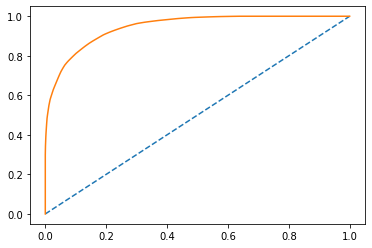

In [242]:
# predict probabilities
probs = DT_model.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
DT_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % DT_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.859


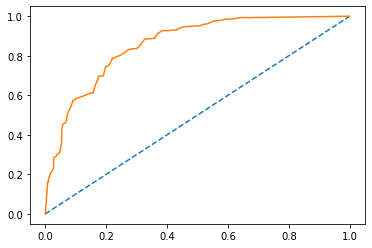

In [243]:
# predict probabilities
probs = DT_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
DT_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % DT_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### RF

In [244]:
from sklearn.ensemble import RandomForestClassifier
RF_model=RandomForestClassifier(n_estimators=100,min_samples_split=10,random_state=1)
RF_model.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [245]:
## Performance Matrix on train data set
Y_ptr_rf = RF_model.predict(X_train)
model_score =RF_model.score(X_train, Y_train)
print(model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_rf))

0.9902468759524535
[[3255   26]
 [  38 3243]]


In [246]:
RF_model.score(X_train, Y_train)

0.9902468759524535

In [247]:
confusion_matrix(Y_train, Y_ptr_rf)

array([[3255,   26],
       [  38, 3243]], dtype=int64)

In [248]:
print(metrics.classification_report(Y_train, Y_ptr_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3281
           1       0.99      0.99      0.99      3281

    accuracy                           0.99      6562
   macro avg       0.99      0.99      0.99      6562
weighted avg       0.99      0.99      0.99      6562



In [249]:
## Performance Matrix on test data set
Y_pte_rf = RF_model.predict(X_test)
model_score = RF_model.score(X_test, Y_test)
print(model_score)
print(metrics.confusion_matrix(Y_test, Y_test_predict))
print(metrics.classification_report(Y_test, Y_pte_rf))

0.9289520426287744
[[1334   67]
 [  53  235]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1401
           1       0.78      0.82      0.80       288

    accuracy                           0.93      1689
   macro avg       0.87      0.88      0.88      1689
weighted avg       0.93      0.93      0.93      1689



In [250]:
RF_model.score(X_test, Y_test)

0.9289520426287744

In [251]:
confusion_matrix(Y_test, Y_pte_rf)

array([[1334,   67],
       [  53,  235]], dtype=int64)

In [252]:
print(metrics.classification_report(Y_test, Y_pte_rf))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1401
           1       0.78      0.82      0.80       288

    accuracy                           0.93      1689
   macro avg       0.87      0.88      0.88      1689
weighted avg       0.93      0.93      0.93      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


AUC: 1.000


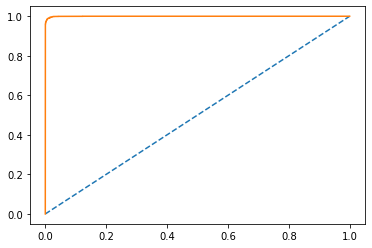

In [253]:
# predict probabilities
probs = RF_model.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
RF_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % RF_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.966


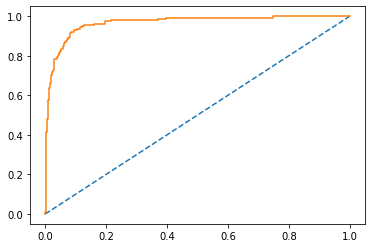

In [254]:
# predict probabilities
probs = RF_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
RF_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % RF_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

## Model Tunning

In [255]:
from sklearn.model_selection import GridSearchCV

### Simple Ensemble

In [256]:
se1_train = pd.DataFrame({'LR1':Y_pprtr_lr1})
se1_train['Ensemble'] = round(np.mean(se1_train,axis=1),0)
se1_test = pd.DataFrame({'LR1':Y_pprte_lr1})
se1_test['Ensemble'] = round(np.mean(se1_test,axis=1),0)
Y_ptr_se1 = np.array(se1_train['Ensemble'].astype('uint8'))
Y_pte_se1 = np.array(se1_test['Ensemble'].astype('uint8'))

### Bagging

In [258]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
rf_bag = RandomForestClassifier()
Bagging_model=BaggingClassifier(base_estimator=rf_bag,n_estimators=100,random_state=1)
Bagging_model.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

In [261]:
## Performance Matrix on train data set
Y_ptr_bag = Bagging_model.predict(X_train)
rf_bag_train_score =Bagging_model.score(X_train, Y_train)
print(rf_bag_train_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_bag))

0.9984760743675709
[[3274    7]
 [   3 3278]]


In [262]:
Bagging_model.score(X_train, Y_train)

0.9984760743675709

In [263]:
confusion_matrix(Y_train, Y_ptr_bag)

array([[3274,    7],
       [   3, 3278]], dtype=int64)

In [264]:
print(metrics.classification_report(Y_train, Y_ptr_bag))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       1.00      1.00      1.00      3281

    accuracy                           1.00      6562
   macro avg       1.00      1.00      1.00      6562
weighted avg       1.00      1.00      1.00      6562



In [266]:
## Performance Matrix on test data set
Y_pte_bag = Bagging_model.predict(X_test)
rf_bag_test_score = Bagging_model.score(X_test, Y_test)
print(rf_bag_test_score)
print(metrics.confusion_matrix(Y_test, Y_pte_bag))

0.940793368857312
[[1340   61]
 [  39  249]]


In [268]:
Bagging_model.score(X_test, Y_test)

0.940793368857312

In [270]:
confusion_matrix(Y_test, Y_pte_bag)

array([[1340,   61],
       [  39,  249]], dtype=int64)

In [272]:
print(metrics.classification_report(Y_test, Y_pte_bag))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1401
           1       0.80      0.86      0.83       288

    accuracy                           0.94      1689
   macro avg       0.89      0.91      0.90      1689
weighted avg       0.94      0.94      0.94      1689



AUC: 1.000


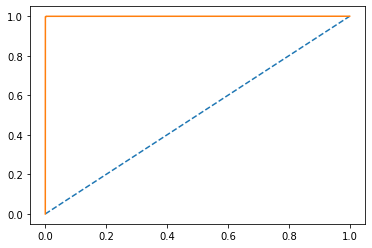

In [274]:
# predict probabilities
probs = Bagging_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bag_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % bag_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.973


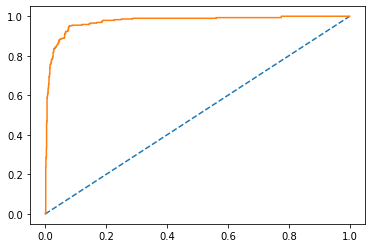

In [275]:
# predict probabilities
probs =  Bagging_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bag_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % bag_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Boosting - AdaBoost

In [277]:
from sklearn.ensemble import AdaBoostClassifier
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model.fit(X_train,Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=1)

In [278]:
## Performance Matrix on train data set
Y_ptr_ADA = ADB_model.predict(X_train)
ADA_train_model_score = ADB_model.score(X_train, Y_train)
print(ADA_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_ADA))

0.8974398049375191
[[2966  315]
 [ 358 2923]]


In [279]:
ADB_model.score(X_train, Y_train)

0.8974398049375191

In [280]:
confusion_matrix(Y_train, Y_ptr_ADA)

array([[2966,  315],
       [ 358, 2923]], dtype=int64)

In [282]:
print(metrics.classification_report(Y_train, Y_ptr_ADA))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3281
           1       0.90      0.89      0.90      3281

    accuracy                           0.90      6562
   macro avg       0.90      0.90      0.90      6562
weighted avg       0.90      0.90      0.90      6562



In [287]:
## Performance Matrix on test data set
Y_pte_ADA = ADB_model.predict(X_test)
ADA_test_model_score = ADB_model.score(X_test, Y_test)
print(ADA_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_ADA))

0.822380106571936
[[1172  229]
 [  71  217]]


In [288]:
ADB_model.score(X_test, Y_test)

0.822380106571936

In [289]:
confusion_matrix(Y_test, Y_pte_ADA)

array([[1172,  229],
       [  71,  217]], dtype=int64)

In [290]:
print(metrics.classification_report(Y_test, Y_pte_ADA))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1401
           1       0.49      0.75      0.59       288

    accuracy                           0.82      1689
   macro avg       0.71      0.80      0.74      1689
weighted avg       0.87      0.82      0.84      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.969


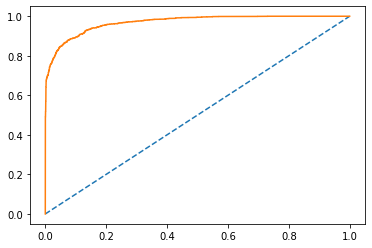

In [291]:
# predict probabilities
probs = ADB_model.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ADA_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % ADA_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.856


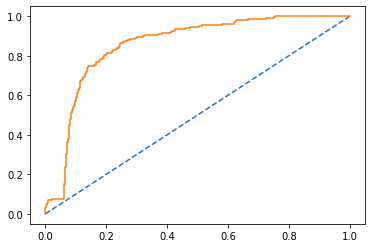

In [293]:
# predict probabilities
probs = ADB_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ADA_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % ADA_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Gradient Boosting 

In [294]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
GB_model=GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, \
                                    min_samples_split=2, min_samples_leaf=1, subsample=1,\
                                    max_features='sqrt', random_state=1)
GB_model.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [295]:
## Performance Matrix on train data set
Y_ptr_GB = GB_model.predict(X_train)
GB_train_model_score = GB_model.score(X_train, Y_train)
print(GB_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_GB))

0.9120694910088387
[[2968  313]
 [ 264 3017]]


In [297]:
 GB_model.score(X_train, Y_train)

0.9120694910088387

In [298]:
confusion_matrix(Y_train, Y_ptr_GB)

array([[2968,  313],
       [ 264, 3017]], dtype=int64)

In [299]:
print(metrics.classification_report(Y_train, Y_ptr_GB))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3281
           1       0.91      0.92      0.91      3281

    accuracy                           0.91      6562
   macro avg       0.91      0.91      0.91      6562
weighted avg       0.91      0.91      0.91      6562



In [300]:
## Performance Matrix on test data set
Y_pte_GB = GB_model.predict(X_test)
GB_test_model_score = GB_model.score(X_test, Y_test)
print(GB_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_GB))

0.872113676731794
[[1242  159]
 [  57  231]]


In [301]:
GB_model.score(X_test, Y_test)

0.872113676731794

In [302]:
confusion_matrix(Y_test, Y_pte_GB)

array([[1242,  159],
       [  57,  231]], dtype=int64)

In [303]:
print(metrics.classification_report(Y_test, Y_pte_GB))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1401
           1       0.59      0.80      0.68       288

    accuracy                           0.87      1689
   macro avg       0.77      0.84      0.80      1689
weighted avg       0.89      0.87      0.88      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.972


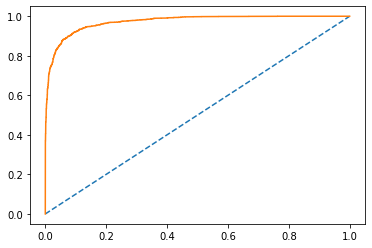

In [304]:
# predict probabilities
probs = GB_model.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
GB_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % GB_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.912


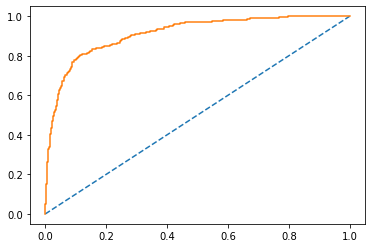

In [305]:
# predict probabilities
probs = GB_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
GB_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % GB_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Boosting - XGBoost

In [306]:
import xgboost as xgb
XGB_model=xgb.XGBClassifier(random_state=1,learning_rate=0.1)
XGB_model.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [307]:
## Performance Matrix on train data set
Y_ptr_XGB = XGB_model.predict(X_train)
XGB_train_model_score = XGB_model.score(X_train, Y_train)
print(XGB_train_model_score)
print(metrics.confusion_matrix(Y_train, Y_ptr_XGB))

0.9245656811947577
[[3045  236]
 [ 259 3022]]


In [308]:
XGB_model.score(X_train, Y_train)

0.9245656811947577

In [309]:
confusion_matrix(Y_train, Y_ptr_XGB)

array([[3045,  236],
       [ 259, 3022]], dtype=int64)

In [310]:
print(metrics.classification_report(Y_train, Y_ptr_XGB))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3281
           1       0.93      0.92      0.92      3281

    accuracy                           0.92      6562
   macro avg       0.92      0.92      0.92      6562
weighted avg       0.92      0.92      0.92      6562



In [311]:
Y_pte_XGB = XGB_model.predict(X_test)
XGB_test_model_score = XGB_model.score(X_test, Y_test)
print(XGB_test_model_score)
print(metrics.confusion_matrix(Y_test, Y_pte_XGB))

0.8875074008288928
[[1267  134]
 [  56  232]]


In [312]:
XGB_model.score(X_test, Y_test)

0.8875074008288928

In [313]:
confusion_matrix(Y_test, Y_pte_XGB)

array([[1267,  134],
       [  56,  232]], dtype=int64)

In [314]:
print(metrics.classification_report(Y_test, Y_pte_XGB))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1401
           1       0.63      0.81      0.71       288

    accuracy                           0.89      1689
   macro avg       0.80      0.85      0.82      1689
weighted avg       0.90      0.89      0.89      1689



AUC: 0.979


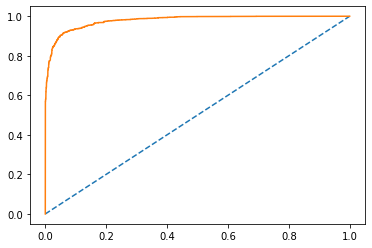

In [315]:
# predict probabilities
probs = XGB_model.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
XGB_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % XGB_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.920


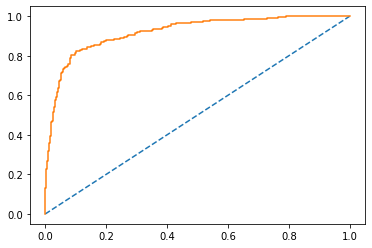

In [316]:
# predict probabilities
probs = XGB_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
XGB_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % XGB_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

## Hyperparameter tuning

### Decision Tree with Grid Search

In [318]:
# Decision tree with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
DT_model_2 = DecisionTreeClassifier()
DT_model_2.fit(X_train,Y_train.values.ravel())

parameters = {'criterion':['gini','entropy'],
        'max_depth':[2,5,10,15],
        'min_samples_split':[2,10,15,20,25,30,60,80,100],
       'min_samples_leaf':[1,7,10,15,20,33],
       'min_impurity_decrease':[0.0001,0.001]}
grid = GridSearchCV(DT_model_2,param_grid = parameters,cv=10,verbose=1,n_jobs=-1)
grid.fit(X_train,Y_train.values.ravel())

Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 3100 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5900 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7252 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8352 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:  3.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [341]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_impurity_decrease': 0.0001,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [342]:
best_grid = grid.best_estimator_
best_grid

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [344]:
DT_model_2 =grid.best_estimator_
DT_model_2.fit(X_train,Y_train.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [345]:
Y_ptr_dt2 = DT_model_2.predict(X_train)
Y_pprtr_dt2 = DT_model_2.predict_proba(X_train)
Y_pte_dt2 = DT_model_2.predict(X_test)
Y_pprte_dt2 = DT_model_2.predict_proba(X_test)

In [346]:
dt2_train_acc=DT_model_2.score(X_train,Y_train) 
dt2_train_acc

0.9833892106065224

In [347]:
confusion_matrix(Y_train,Y_ptr_dt2)

array([[3214,   67],
       [  42, 3239]], dtype=int64)

In [348]:
print(classification_report(Y_train,Y_ptr_dt2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3281
           1       0.98      0.99      0.98      3281

    accuracy                           0.98      6562
   macro avg       0.98      0.98      0.98      6562
weighted avg       0.98      0.98      0.98      6562



In [349]:
dt2_test_acc=DT_model_2.score(X_test,Y_test) 
dt2_test_acc

0.8709295441089402

In [351]:
confusion_matrix(Y_test,Y_pte_dt2)

array([[1239,  162],
       [  56,  232]], dtype=int64)

In [352]:
print(classification_report(Y_test,Y_pte_dt2))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1401
           1       0.59      0.81      0.68       288

    accuracy                           0.87      1689
   macro avg       0.77      0.84      0.80      1689
weighted avg       0.89      0.87      0.88      1689



AUC: 0.994


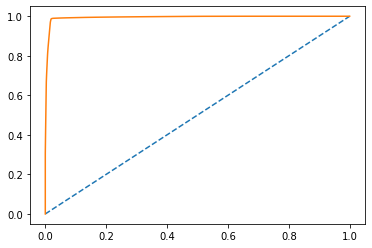

In [332]:
# predict probabilities
probs = DT_model_2.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
DT2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % DT2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.840


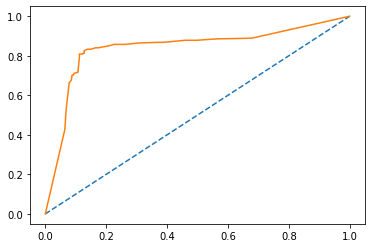

In [333]:
# predict probabilities
probs = DT_model_2.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
DT2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % DT2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

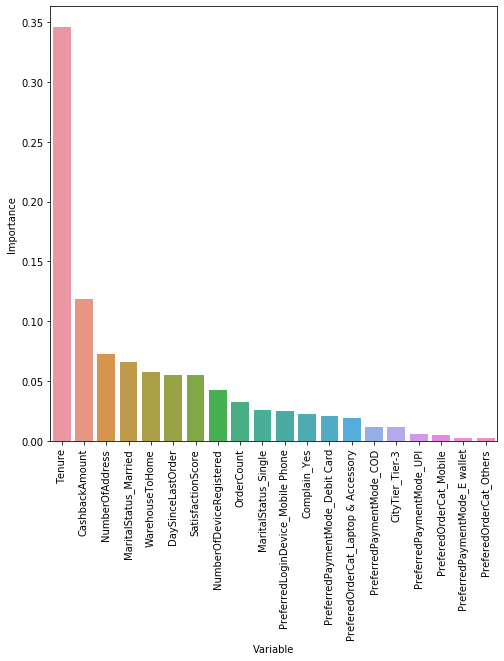

In [354]:
importance = pd.DataFrame(DT_model_2.feature_importances_,columns=['Importance'])
importance['Variable'] = X_train.columns
importance=importance[['Variable','Importance']]
sorted_idx = DT_model_2.feature_importances_.argsort()[::-1]
fig,axes = plt.subplots(figsize=(8,8))
sns.barplot(x=importance['Variable'][sorted_idx],y='Importance',data = importance,ci=0)
axes.set_xticklabels(labels = importance['Variable'][sorted_idx],rotation=90)
plt.show()

### Random Forest Tree with Grid Search

In [355]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier()
parameters = {'n_estimators':[60,80,100,200,300],
             'min_samples_split':[2,8,12],
             'min_samples_leaf':[1,5,10],
             'max_features': ['auto'],
             'min_impurity_decrease':[0.00001,0.0001,0.001]}
grid = GridSearchCV(estimator=rf2,param_grid=parameters,cv=10,n_jobs=-1,verbose=1)
grid.fit(X_train,Y_train.values.ravel())

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 13.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [356]:
grid.best_params_

{'max_features': 'auto',
 'min_impurity_decrease': 1e-05,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [357]:
rf2 =grid.best_estimator_
rf2.fit(X_train,Y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [358]:
Y_ptr_rf2 = rf2.predict(X_train)
Y_pprtr_rf2 = rf2.predict_proba(X_train)
Y_pte_rf2 = rf2.predict(X_test)
Y_pprte_rf2 = rf2.predict_proba(X_test)

In [359]:
rf2_train_acc=rf2.score(X_train,Y_train) 
rf2_train_acc

0.9993904297470283

In [360]:
confusion_matrix(Y_train,Y_ptr_rf2)

array([[3279,    2],
       [   2, 3279]], dtype=int64)

In [361]:
print(classification_report(Y_train,Y_ptr_rf2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       1.00      1.00      1.00      3281

    accuracy                           1.00      6562
   macro avg       1.00      1.00      1.00      6562
weighted avg       1.00      1.00      1.00      6562



In [362]:
rf2_test_acc=rf2.score(X_test,Y_test) 
rf2_test_acc

0.9467140319715808

In [363]:
confusion_matrix(Y_test,Y_pte_rf2)

array([[1347,   54],
       [  36,  252]], dtype=int64)

In [364]:
print(classification_report(Y_test,Y_pte_rf2))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1401
           1       0.82      0.88      0.85       288

    accuracy                           0.95      1689
   macro avg       0.90      0.92      0.91      1689
weighted avg       0.95      0.95      0.95      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


AUC: 1.000


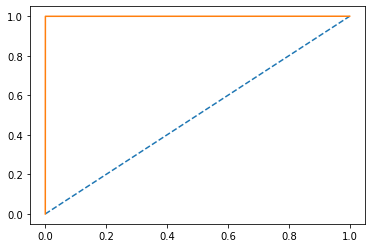

In [365]:
# predict probabilities
probs = rf2.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % rf2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.979


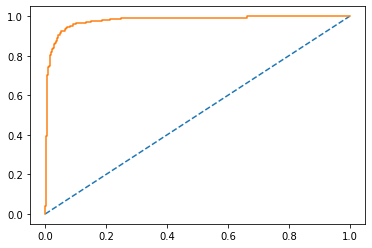

In [366]:
# predict probabilities
probs = rf2.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % rf2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

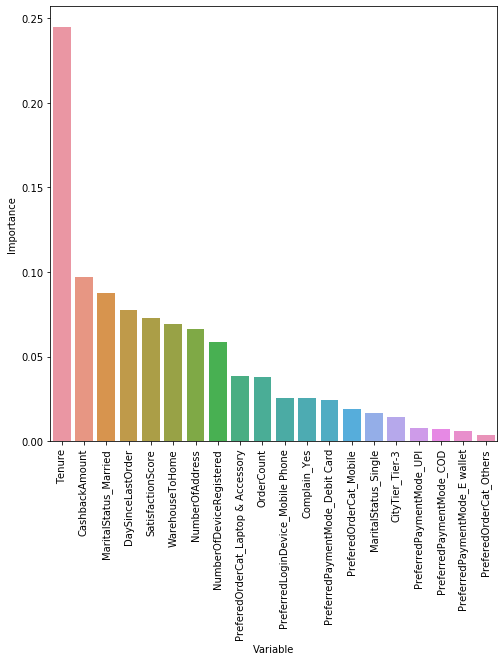

In [367]:
importance = pd.DataFrame(rf2.feature_importances_,columns=['Importance'])
importance['Variable'] = X_train.columns
importance=importance[['Variable','Importance']]
sorted_idx = rf2.feature_importances_.argsort()[::-1]
fig,axes = plt.subplots(figsize=(8,8))
sns.barplot(x=importance['Variable'][sorted_idx],y='Importance',data = importance,ci=0)
axes.set_xticklabels(labels = importance['Variable'][sorted_idx],rotation=90)
plt.show()


### KNN with Grid Search

In [368]:
# KNN model
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = pd.DataFrame(std.fit_transform(X_train),columns = X_train.columns)
X_test_std = pd.DataFrame(std.fit_transform(X_test),columns = X_test.columns)
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier()
params = {'n_neighbors':range(2,11),
         'p':[2,3],
         'metric':['manhattan','chebyshev','minkowski']}
grid = GridSearchCV(estimator=knn1,param_grid=params,cv=10,n_jobs=-1,verbose=1)
grid.fit(X_train_std,Y_train.values.ravel())

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['manhattan', 'chebyshev', 'minkowski'],
                         'n_neighbors': range(2, 11), 'p': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [369]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'p': 2}

In [370]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [371]:
knn2 =grid.best_estimator_
knn2.fit(X_train_std,Y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [372]:
Y_ptr_knn2 = knn2.predict(X_train_std)
Y_pprtr_knn2 = knn2.predict_proba(X_train_std)
Y_pte_knn2 = knn2.predict(X_test_std)
Y_pprte_knn2 = knn2.predict_proba(X_test_std)

In [373]:
knn2_train_acc=knn2.score(X_train_std,Y_train) 
knn2_train_acc

0.9865894544346235

In [374]:
confusion_matrix(Y_train,Y_ptr_knn2)

array([[3281,    0],
       [  88, 3193]], dtype=int64)

In [375]:
print(classification_report(Y_train,Y_ptr_knn2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3281
           1       1.00      0.97      0.99      3281

    accuracy                           0.99      6562
   macro avg       0.99      0.99      0.99      6562
weighted avg       0.99      0.99      0.99      6562



In [376]:
knn2_test_acc=knn2.score(X_test_std,Y_test) 
knn2_test_acc

0.9348727057430433

In [377]:
confusion_matrix(Y_test,Y_pte_knn2)

array([[1340,   61],
       [  49,  239]], dtype=int64)

In [378]:
print(classification_report(Y_test,Y_pte_knn2))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1401
           1       0.80      0.83      0.81       288

    accuracy                           0.93      1689
   macro avg       0.88      0.89      0.89      1689
weighted avg       0.94      0.93      0.94      1689



AUC: 0.999


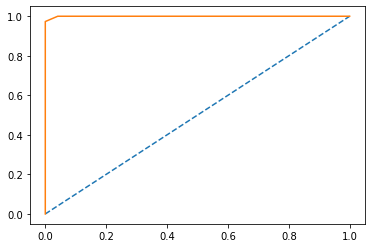

In [385]:
# predict probabilities
probs = knn2.fit(X_train_std,Y_train.values.ravel()).predict_proba(X_train_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
knn2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % knn2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.949


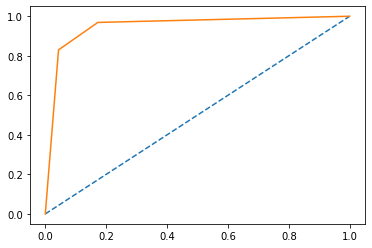

In [386]:
# predict probabilities
probs = knn2.predict_proba(X_test_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
knn2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % knn2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Support vector classifier with Grid Search

In [384]:
from sklearn.svm import SVC
svc2 = SVC()
params = {'C':[0.01,1,10,20],
         'kernel':['linear','poly','rbf','sigmoid'],
         'probability':[True]}
grid = GridSearchCV(estimator=svc2,param_grid=params,cv=10,n_jobs=-1,verbose=1)
grid.fit(X_train_std,Y_train.values.ravel())

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 18.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 1, 10, 20],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [387]:
grid.best_params_

{'C': 20, 'kernel': 'rbf', 'probability': True}

In [388]:
grid.best_estimator_

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [390]:
svc2 =grid.best_estimator_
svc2.fit(X_train_std,Y_train.values.ravel())

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [391]:
Y_ptr_svc2 = svc2.predict(X_train_std)
Y_pprtr_svc2 = svc2.predict_proba(X_train_std)
Y_pte_svc2 = svc2.predict(X_test_std)
Y_pprte_svc2 = svc2.predict_proba(X_test_std)

In [392]:
svc2_train_acc=svc2.score(X_train_std,Y_train) 
svc2_train_acc

0.9852179213654374

In [393]:
confusion_matrix(Y_train,Y_ptr_svc2)

array([[3210,   71],
       [  26, 3255]], dtype=int64)

In [394]:
print(classification_report(Y_train,Y_ptr_svc2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3281
           1       0.98      0.99      0.99      3281

    accuracy                           0.99      6562
   macro avg       0.99      0.99      0.99      6562
weighted avg       0.99      0.99      0.99      6562



In [405]:
svc2_test_acc=svc2.score(X_test_std,Y_test) 
svc2_test_acc

0.8768502072232089

In [406]:
confusion_matrix(Y_test,Y_pte_svc2)

array([[1201,  200],
       [   8,  280]], dtype=int64)

In [407]:
print(classification_report(Y_test,Y_pte_svc2))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1401
           1       0.58      0.97      0.73       288

    accuracy                           0.88      1689
   macro avg       0.79      0.91      0.82      1689
weighted avg       0.92      0.88      0.89      1689



AUC: 0.997


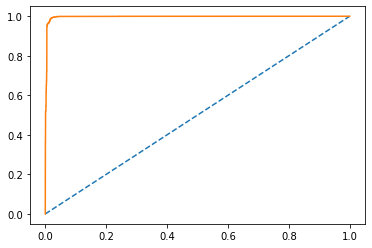

In [408]:
# predict probabilities
probs = svc2.fit(X_train_std,Y_train.values.ravel()).predict_proba(X_train_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
svc2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % svc2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.972


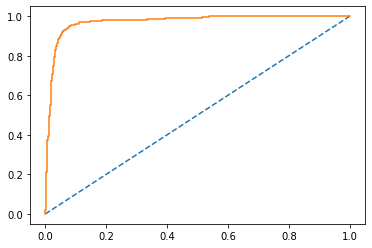

In [409]:
# predict probabilities
probs = svc2.predict_proba(X_test_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
svc2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % svc2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Bagging with Grid Serach

In [415]:
from sklearn.model_selection import GridSearchCV

Bagging_model=BaggingClassifier(RandomForestClassifier(n_estimators=100))
param_grid = { 
    'base_estimator__max_depth': [7,8],
    'base_estimator__max_features': [5,7],
    'base_estimator__min_samples_leaf': [10,30],
    'base_estimator__min_samples_split': [5, 10],
    'base_estimator__n_estimators': [100]
}
grid_search = GridSearchCV(estimator = Bagging_model, param_grid = param_grid, cv = 10)
grid_search.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

GridSearchCV(cv=10, error_score=nan,
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                                               ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features='auto',
                                                                               max_leaf_nodes=None,
                                                                               max_samples=None,
                                                                               min_impurity_decrease=0.0,
                                                                               mi

In [416]:
grid_search.best_params_

{'base_estimator__max_depth': 8,
 'base_estimator__max_features': 5,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 5,
 'base_estimator__n_estimators': 100}

In [433]:
bag2 = grid_search.best_estimator_
bag2

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=8,
                                                        max_features=5,
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=10,
                                                        min_samples_split=5,
                                                        min_weight_fraction_leaf=0.0,
            

In [434]:
Y_ptr_bag2 = bag2.predict(X_train)
Y_pte_bag2 = bag2.predict(X_test)

In [436]:
bag2_train_acc=bag2.score(X_train,Y_train) 
bag2_train_acc

0.9138982017677537

In [437]:
confusion_matrix(Y_train,Y_ptr_bag2)

array([[3007,  274],
       [ 291, 2990]], dtype=int64)

In [438]:
print(classification_report(Y_train,Y_ptr_bag2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3281
           1       0.92      0.91      0.91      3281

    accuracy                           0.91      6562
   macro avg       0.91      0.91      0.91      6562
weighted avg       0.91      0.91      0.91      6562



In [439]:
bag2_test_acc=bag2.score(X_test,Y_test) 
bag2_test_acc

0.8644168146832445

In [440]:
confusion_matrix(Y_test,Y_pte_bag2)

array([[1237,  164],
       [  65,  223]], dtype=int64)

In [441]:
print(classification_report(Y_test,Y_pte_bag2))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1401
           1       0.58      0.77      0.66       288

    accuracy                           0.86      1689
   macro avg       0.76      0.83      0.79      1689
weighted avg       0.89      0.86      0.87      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.973


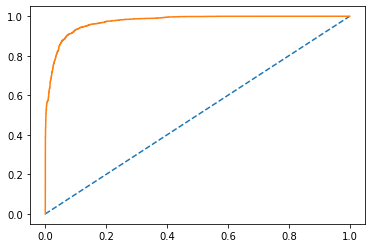

In [442]:
# predict probabilities
probs = bag2.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bag2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % bag2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.724


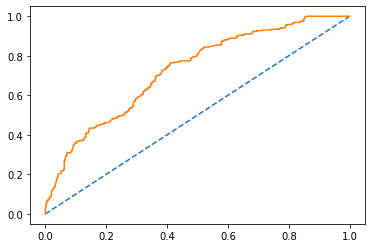

In [443]:
# predict probabilities
probs = bag2.predict_proba(X_test_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bag2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % bag2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

In [445]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag2], axis=0)
feature_importances

array([0.33812619, 0.03615881, 0.05140987, 0.0565956 , 0.04655883,
       0.02440797, 0.07134017, 0.07681337, 0.02481407, 0.0058075 ,
       0.00121753, 0.02423678, 0.00128581, 0.00221083, 0.051287  ,
       0.02338742, 0.00155709, 0.13068461, 0.01221506, 0.01988547])

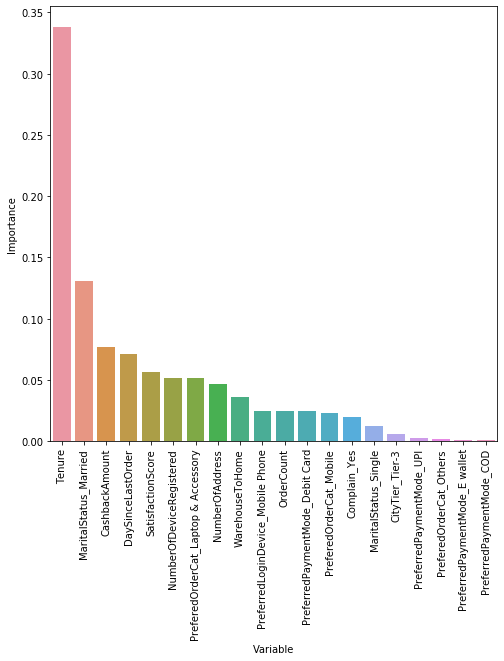

In [446]:
importance = pd.DataFrame(feature_importances,columns=['Importance'])
importance['Variable'] = X_train.columns
importance=importance[['Variable','Importance']]
sorted_idx = feature_importances.argsort()[::-1]
fig,axes = plt.subplots(figsize=(8,8))
sns.barplot(x=importance['Variable'][sorted_idx],y='Importance',data = importance,ci=0)
axes.set_xticklabels(labels = importance['Variable'][sorted_idx],rotation=90)
plt.show()

### GridSearch - AdaBoost

In [448]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

Boosting_model= AdaBoostClassifier()
param_grid = {  'n_estimators': [100,200,300],
              'learning_rate':[0.1,0.001,0.01]
              }
grid_search = GridSearchCV(estimator = Boosting_model, param_grid = param_grid,scoring='accuracy', n_jobs=1,cv = 10)
grid_search.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.001, 0.01],
                         'n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [449]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [450]:
ada2 = grid_search.best_estimator_
ada2

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=300, random_state=None)

In [451]:
Y_ptr_ada2 = ada2.predict(X_train)
Y_pte_ada2 = ada2.predict(X_test)

In [452]:
confusion_matrix(Y_train,Y_ptr_ada2)

array([[2862,  419],
       [ 363, 2918]], dtype=int64)

In [453]:
ada2_train_acc=ada2.score(X_train,Y_train) 
ada2_train_acc

0.8808290155440415

In [454]:
print(classification_report(Y_train,Y_ptr_ada2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3281
           1       0.87      0.89      0.88      3281

    accuracy                           0.88      6562
   macro avg       0.88      0.88      0.88      6562
weighted avg       0.88      0.88      0.88      6562



In [455]:
confusion_matrix(Y_test,Y_pte_ada2)

array([[1154,  247],
       [  60,  228]], dtype=int64)

In [456]:
ada2_test_acc=best_grid.score(X_test,Y_test) 
ada2_test_acc

0.8709295441089402

In [457]:
print(classification_report(Y_test,Y_pte_ada2))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1401
           1       0.48      0.79      0.60       288

    accuracy                           0.82      1689
   macro avg       0.72      0.81      0.74      1689
weighted avg       0.87      0.82      0.83      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.952


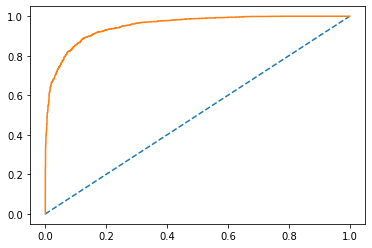

In [458]:
# predict probabilities
probs = ada2.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ada2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % ada2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.877


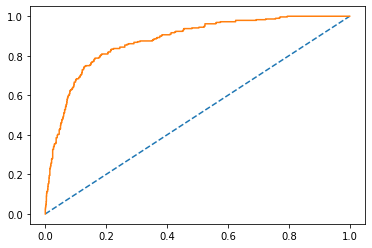

In [459]:
# predict probabilities
probs = ada2.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ada2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % ada2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

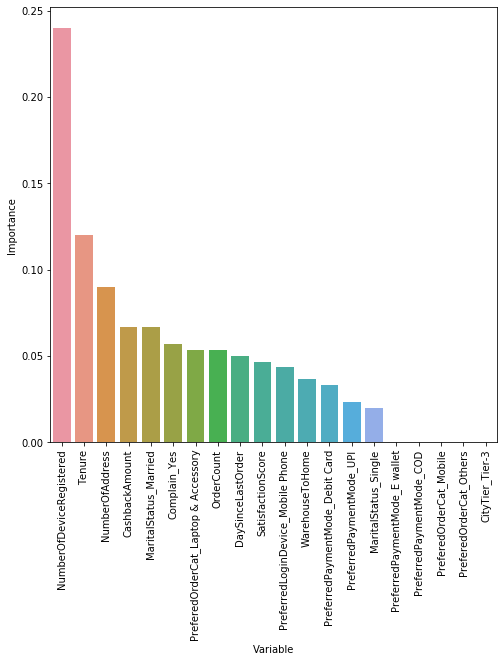

In [460]:
importance = pd.DataFrame(ada2.feature_importances_,columns=['Importance'])
importance['Variable'] = X_train.columns
importance=importance[['Variable','Importance']]
sorted_idx = ada2.feature_importances_.argsort()[::-1]
fig,axes = plt.subplots(figsize=(8,8))
sns.barplot(x=importance['Variable'][sorted_idx],y='Importance',data = importance,ci=0)
axes.set_xticklabels(labels = importance['Variable'][sorted_idx],rotation=90)
plt.show()

### GB _ With GridSearch

In [462]:
GBoosting_model = GradientBoostingClassifier(random_state=1)
param_grid = {   
    'max_depth':[4,5,6], # 4 -- 4,5
    'n_estimators': [100,200],#300 -- 100,80,200,300
    'learning_rate': [0.01,0.1],#0.01 -- 0.1, 0.3,0.8
    'min_samples_split':[10,20],#50 -- 30,40
     'min_samples_leaf':[10,20]#30 --10,20
}
grid_search = GridSearchCV(estimator = GBoosting_model, param_grid = param_grid, cv = 10)
grid_search.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_...
                 

In [463]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 200}

In [464]:
gb2 = grid_search.best_estimator_
gb2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [465]:
Y_ptr_gb2 = gb2.predict(X_train)
Y_pte_gb2 = gb2.predict(X_test)

In [466]:
confusion_matrix(Y_train,Y_ptr_gb2)

array([[3280,    1],
       [   0, 3281]], dtype=int64)

In [467]:
gb2_train_acc=gb2.score(X_train,Y_train) 
gb2_train_acc

0.999847607436757

In [468]:
print(classification_report(Y_train,Y_ptr_gb2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       1.00      1.00      1.00      3281

    accuracy                           1.00      6562
   macro avg       1.00      1.00      1.00      6562
weighted avg       1.00      1.00      1.00      6562



In [469]:
gb2_test_acc=gb2.score(X_test,Y_test) 
gb2_test_acc

0.9680284191829485

In [470]:
confusion_matrix(Y_test,Y_pte_gb2)

array([[1368,   33],
       [  21,  267]], dtype=int64)

In [471]:
print(classification_report(Y_test,Y_pte_gb2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1401
           1       0.89      0.93      0.91       288

    accuracy                           0.97      1689
   macro avg       0.94      0.95      0.94      1689
weighted avg       0.97      0.97      0.97      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 1.000


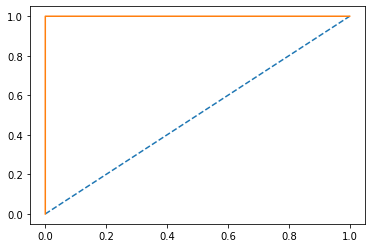

In [472]:
# predict probabilities
probs = gb2.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
gb2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % gb2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.710


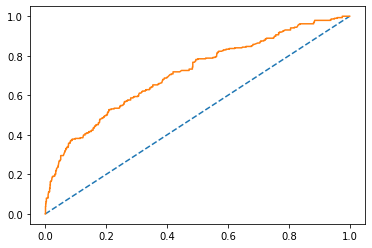

In [473]:
# predict probabilities
probs = gb2.predict_proba(X_test_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
gb2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % gb2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

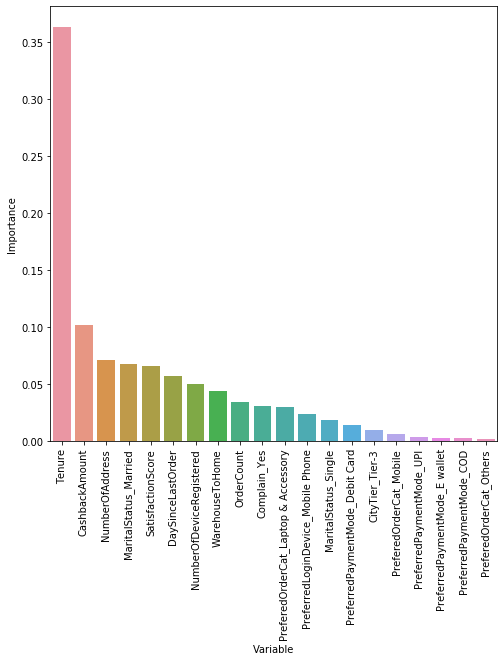

In [474]:
importance = pd.DataFrame(gb2.feature_importances_,columns=['Importance'])
importance['Variable'] = X_train.columns
importance=importance[['Variable','Importance']]
sorted_idx = gb2.feature_importances_.argsort()[::-1]
fig,axes = plt.subplots(figsize=(8,8))
sns.barplot(x=importance['Variable'][sorted_idx],y='Importance',data = importance,ci=0)
axes.set_xticklabels(labels = importance['Variable'][sorted_idx],rotation=90)
plt.show()

### Grid Search - XGBoost

In [475]:
XGBoosting_model = xgb.XGBClassifier(random_state=1)
param_grid = {   
    'max_depth':[5,6,7],
    'n_estimators': [50,80,100],
    'learning_rate': [0.1,0.01,0.03],
    'min_child_weight':[5,10,15],
    'n_jobs':[1]}

grid_search = GridSearchCV(estimator = XGBoosting_model, param_grid = param_grid, cv = 5)
grid_search.fit(X_train, Y_train)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01, 0.03],
                         'max_depth': [5, 6, 7],
                         'min_child_weight': [5, 10, 15],
         

In [489]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 100,
 'n_jobs': 1}

In [490]:
xgb2 = grid_search.best_estimator_
xgb2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [491]:
Y_ptr_xgb2 = xgb2.predict(X_train)
Y_pte_xgb2 = xgb2.predict(X_test)

In [492]:
confusion_matrix(Y_train,Y_ptr_xgb2)

array([[3233,   48],
       [  36, 3245]], dtype=int64)

In [493]:
xgb2_train_acc=xgb2.score(X_train,Y_train) 
xgb2_train_acc

0.9871990246875952

In [494]:
print(classification_report(Y_train,Y_ptr_xgb2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3281
           1       0.99      0.99      0.99      3281

    accuracy                           0.99      6562
   macro avg       0.99      0.99      0.99      6562
weighted avg       0.99      0.99      0.99      6562



In [495]:
confusion_matrix(Y_test,Y_pte_xgb2)

array([[1330,   71],
       [  44,  244]], dtype=int64)

In [496]:
xgb2_test_acc=best_grid.score(X_test,Y_test) 
xgb2_test_acc

0.8709295441089402

In [497]:
print(classification_report(Y_test,Y_pte_xgb2))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1401
           1       0.77      0.85      0.81       288

    accuracy                           0.93      1689
   macro avg       0.87      0.90      0.88      1689
weighted avg       0.94      0.93      0.93      1689



C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.999


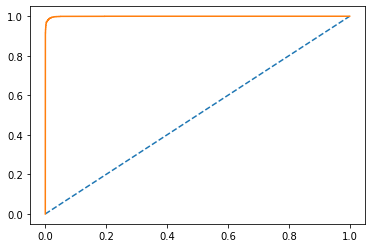

In [498]:
# predict probabilities
probs = xgb2.fit(X_train,Y_train).predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
xgb2_train_auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % xgb2_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.743


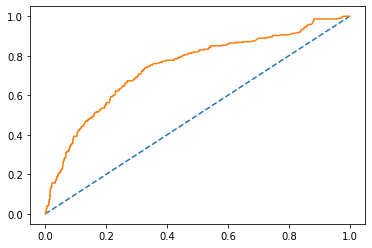

In [500]:
# predict probabilities
probs = xgb2.predict_proba(X_test_std)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
xgb2_test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % xgb2_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

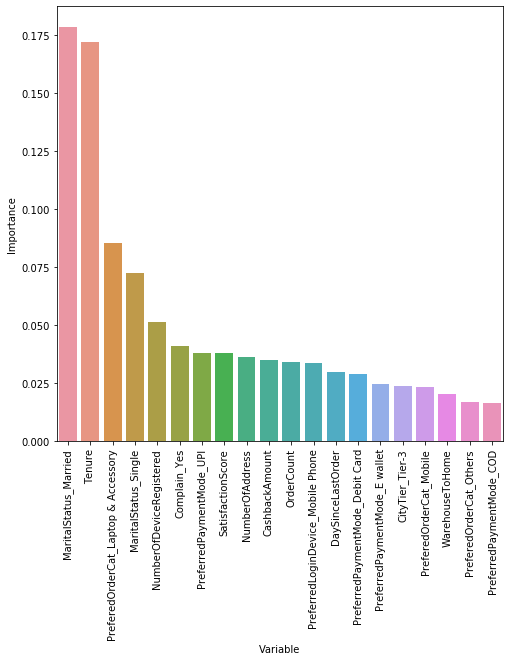

In [501]:
importance = pd.DataFrame(xgb2.feature_importances_,columns=['Importance'])
importance['Variable'] = X_train.columns
importance=importance[['Variable','Importance']]
sorted_idx = xgb2.feature_importances_.argsort()[::-1]
fig,axes = plt.subplots(figsize=(8,8))
sns.barplot(x=importance['Variable'][sorted_idx],y='Importance',data = importance,ci=0)
axes.set_xticklabels(labels = importance['Variable'][sorted_idx],rotation=90)
plt.show()

In [504]:
# Comparing the models as per performance on training set
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
mod = ['Logreg','LDA','KNN','NB','SVC','Decision-Tree','Random Forest','Bagging',
       'AdaBoost','Gradient Boosting','Extreme Gardient Boosting','Simple Ensemble',
       'Decision Tree With GS','Random Forest With GS', 'KNN With GS','SVC With GS','Bagging With GS',
       'AdaBoost With GS','Gradient Boosting With GS','Extreme Gardient Boosting With GS']
acc=[]
pre=[]
rec=[]
auc=[]
training_pred = [Y_ptr_lr1,Y_ptr_ld,Y_ptr_knn,Y_ptr_nb,Y_ptr_svc,Y_ptr_dt,Y_ptr_rf,
                 Y_ptr_bag,Y_ptr_ADA,Y_ptr_GB,Y_ptr_XGB,Y_ptr_se1,Y_ptr_dt2, Y_ptr_rf2,
                Y_ptr_knn2,Y_ptr_svc2,Y_ptr_bag2,Y_ptr_ada2, Y_ptr_gb2, Y_ptr_xgb2]
for i in training_pred:
    acc.append(accuracy_score(Y_train,i))
    pre.append(precision_score(Y_train,i))
    rec.append(recall_score(Y_train,i))
    auc.append(roc_auc_score(Y_train,i))
metric_df_train = pd.DataFrame({'Model':mod,'Accuracy':acc,'Precision':pre,'Recall':rec,'AUC':auc})    
metric_df_train   

,Model,Accuracy,Precision,Recall,AUC
0,Logreg,0.835721,0.826952,0.849131,0.835721
1,LDA,0.836788,0.819549,0.863761,0.836788
2,KNN,0.924566,0.874060,0.992076,0.924566
3,NB,0.758001,0.736255,0.804023,0.758001
4,SVC,0.837245,0.825345,0.855532,0.837245
5,Decision-Tree,0.859494,0.856884,0.863151,0.859494
6,Random Forest,0.990247,0.992046,0.988418,0.990247
7,Bagging,0.998476,0.997869,0.999086,0.998476
8,AdaBoost,0.897440,0.902718,0.890887,0.897440
9,Gradient Boosting,0.912069,0.906006,0.919537,0.912069


In [505]:
# Comparing the models as per performance on testing set
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
mod = ['Logreg','LDA','KNN','NB','SVC','Decision-Tree','Random Forest','Bagging',
       'AdaBoost','Gradient Boosting','Extreme Gardient Boosting','Simple Ensemble',
       'Decision Tree With GS','Random Forest With GS', 'KNN With GS','SVC With GS','Bagging With GS',
       'AdaBoost With GS','Gradient Boosting With GS','Extreme Gardient Boosting With GS']
acc=[]
pre=[]
rec=[]
auc=[]
testing_pred = [Y_pte_lr1,Y_pte_ld,Y_pte_knn,Y_pte_nb,Y_pte_svc,Y_pte_dt,Y_pte_rf,
                 Y_pte_bag,Y_pte_ADA,Y_pte_GB,Y_pte_XGB,Y_pte_se1,Y_pte_dt2, Y_pte_rf2,
                Y_pte_knn2,Y_pte_svc2,Y_pte_bag2,Y_pte_ada2, Y_pte_gb2, Y_pte_xgb2]
for i in testing_pred:
    acc.append(accuracy_score(Y_test,i))
    pre.append(precision_score(Y_test,i))
    rec.append(recall_score(Y_test,i))
    auc.append(roc_auc_score(Y_test,i))
metric_df_test = pd.DataFrame({'Model':mod,'Accuracy':acc,'Precision':pre,'Recall':rec,'AUC':auc})    
metric_df_test

,Model,Accuracy,Precision,Recall,AUC
0,Logreg,0.793961,0.440711,0.774306,0.786153
1,LDA,0.780935,0.423507,0.788194,0.783819
2,KNN,0.793369,0.446585,0.885417,0.829932
3,NB,0.684429,0.298188,0.628472,0.662202
4,SVC,0.793961,0.441860,0.791667,0.793050
5,Decision-Tree,0.790409,0.429487,0.697917,0.753669
6,Random Forest,0.928952,0.778146,0.815972,0.884075
7,Bagging,0.940793,0.803226,0.864583,0.910522
8,AdaBoost,0.822380,0.486547,0.753472,0.795009
9,Gradient Boosting,0.872114,0.592308,0.802083,0.844296
